In [21]:
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

In [61]:
from skimage.io import imread, imshow
from skimage.morphology import skeletonize, skeletonize_3d, thin
import numpy as np
from skimage.measure import regionprops_table
from microfilm.microplot import microshow

In [41]:
img = imread("data/Simonsen-mitome-deconv-plate01-batch1-02-tiff/composite_Simonsen-mitome-deconv-plate01-batch1-02--s444246--XWNeg9--W0077--P008--T00001--Z001--C01.ome.tif")
#img = imread("data/Simonsen-mitome-deconv-plate01-batch1-02-tiff/composite_Simonsen-mitome-deconv-plate01-batch1-03--s15963--ULK1--W0058--P001--T00001--Z001--C01.ome.tif")
img = img[500:1500, 500:1500,:]

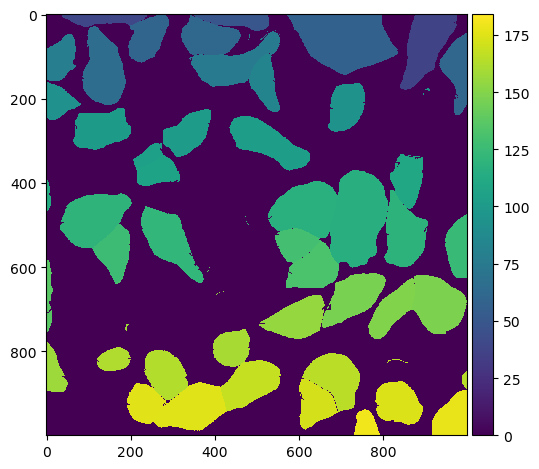

In [52]:
nuclei_channel = img[:,:,0]
sigma_outline = 1
#nuclei_segmented = cle.gauss_otsu_labeling(nuclei_channel, outline_sigma=sigma_outline)
#cell_regions = np.array(cle.dilate_labels(nuclei_segmented, radius=40))
cell_regions = imread("data/Simonsen-mitome-deconv-plate01-batch1-02-cp_masks.png/composite_Simonsen-mitome-deconv-plate01-batch1-02--s444246--XWNeg9--W0077--P008--T00001--Z001--C01.ome_cp_masks.png")
cell_regions = cell_regions[500:1500, 500:1500]
imshow(cell_regions)

In [78]:
mito_channel =  img[:,:,1]
liso_channel =  img[:,:,2]
mito_normalized = np.array(cle.create_like(mito_channel))
labels = list(np.unique(cell_regions))
labels.remove(0)
for cellid in labels[:]:
    mask = cell_regions == cellid
    region = mito_channel[mask]
    mito_normalized[mask] =  region / region.max() * 255

#fig, axs = plt.subplots(1, 2, figsize=(12, 12))
#cle.imshow(mito_channel, labels=False, plot=axs[0])
#cle.imshow(mito_normalized, labels=False, plot=axs[1])

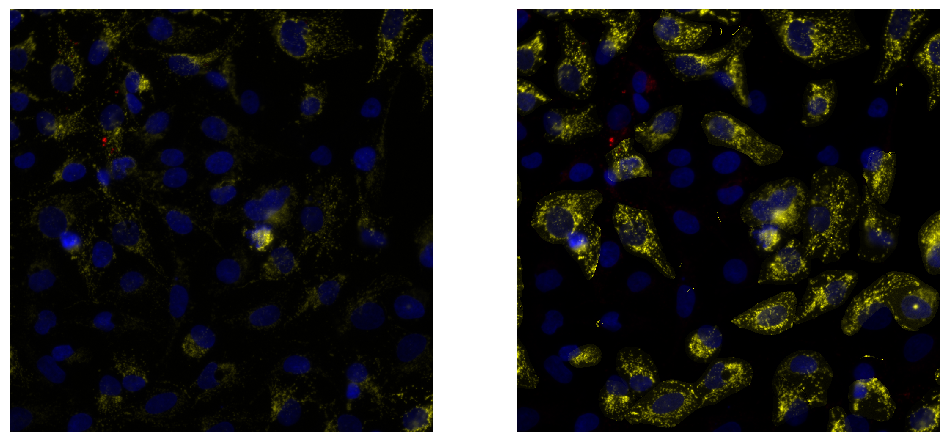

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
normalized = np.dstack([nuclei_channel, mito_normalized, liso_channel])
microshow(np.rollaxis(img, axis=2), cmaps=['pure_blue', 'pure_yellow', 'pure_red'], ax=axs[0])
microshow(np.rollaxis(normalized, axis=2), cmaps=['pure_blue', 'pure_yellow', 'pure_red'], ax=axs[1])

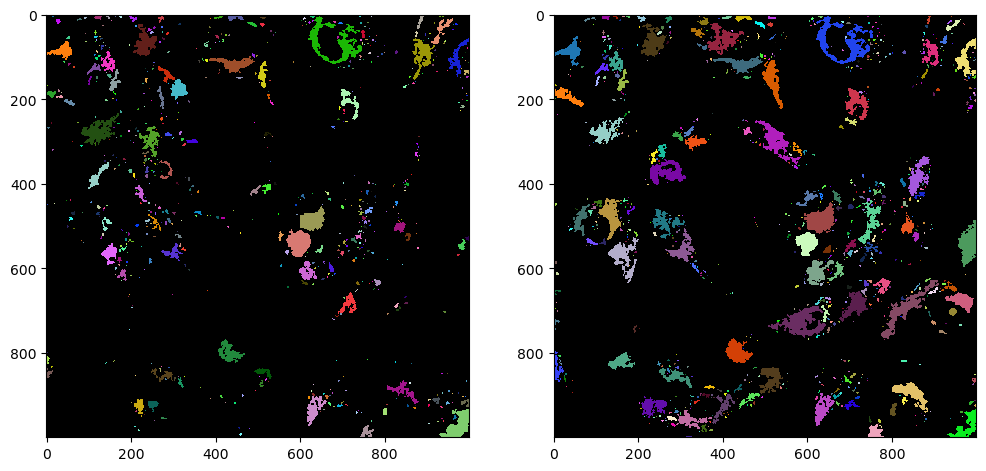

In [57]:
sigma_outline = 1
segmented = cle.gauss_otsu_labeling(mito_channel, outline_sigma=sigma_outline)
segmented_normalized = cle.gauss_otsu_labeling(mito_normalized, outline_sigma=sigma_outline)

fig, axs = plt.subplots(1, 2, figsize=(12, 12))
cle.imshow(segmented, labels=True, plot=axs[0])
cle.imshow(segmented_normalized, labels=True, plot=axs[1])

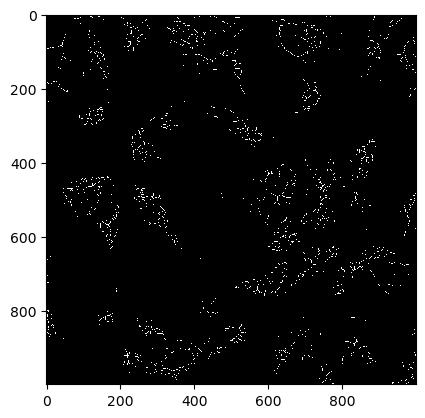

In [58]:
cle.imshow(thin(np.array(segmented_normalized > 0)))

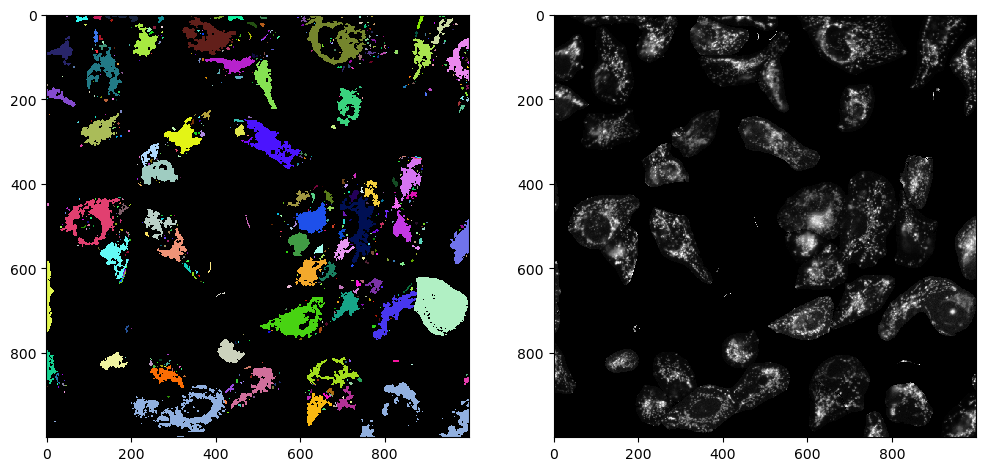

In [60]:
mito_seg_comb = np.zeros_like(mito_channel, dtype=np.uint32)
for cellid in labels[:200]:
    mask = cell_regions == cellid
    region = np.where(mask, mito_channel, 0)
    region = region / region.max() * 255
    mito_seg = np.array(cle.gauss_otsu_labeling(region, outline_sigma=sigma_outline), dtype=np.uint32)
    shift = np.ones_like(mito_seg) * (mito_seg > 0) *mito_seg_comb.max()
    mito_seg_comb +=  mito_seg + shift
    
np.array(np.where(mito_seg > 0, mito_seg_comb.max(), 0), dtype=np.uint32)
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
cle.imshow(mito_seg_comb, labels=True, plot=axs[0])
cle.imshow(mito_normalized, labels=False, plot=axs[1])

In [69]:
props = regionprops_table(
    mito_seg_comb,
    properties=('centroid', 'orientation', 'euler_number', "equivalent_diameter_area","feret_diameter_max"),
)
import pandas as pd
df = pd.DataFrame(props)

In [76]:
dfa = df[["equivalent_diameter_area", "feret_diameter_max","euler_number"]]
dfa["ratio"] = df["equivalent_diameter_area"] / df["feret_diameter_max"]

/tmp/ipykernel_20889/3539192023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa["ratio"] = df["equivalent_diameter_area"] / df["feret_diameter_max"]


array([[<Axes: title={'center': 'equivalent_diameter_area'}>,
        <Axes: title={'center': 'feret_diameter_max'}>],
       [<Axes: title={'center': 'euler_number'}>,
        <Axes: title={'center': 'ratio'}>]], dtype=object)

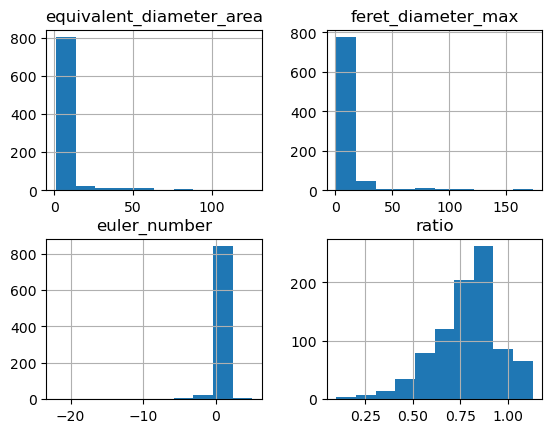

In [77]:
dfa.hist()